### Merge datasets

In [54]:
import os
import sys
import pandas as pd


data_path = os.path.join(os.getcwd(), '../data')
src_path = os.path.join(os.getcwd(), '../src')
sys.path.append(src_path)

from utils import merge_csvs, get_relevant_info_by_group

In [55]:
merge_csvs(data_path, 'cat_data.csv')
df = pd.read_csv(os.path.join(data_path, 'cat_data.csv'))
df.rename({'Unnamed: 0': 'Municipality'}, axis=1, inplace=True)
df.set_index('Municipality', inplace=True)


---

### Collapse column names

In [56]:
cols = list(df.columns)
cols.sort()
cols[:5]

['Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_of_2_years_and_over_Total',
 'Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_that_can_read_Catalan_Read',
 'Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_that_can_speak_Catalan_Speak',
 'Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_that_can_write_Catalan_Write',
 "Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_that_doesn't_understand_Catalan_Do_not_understand"]

In [57]:
coldf = pd.DataFrame(cols, columns=['name'])
coldf.loc[:, 'main'], coldf.loc[:, 'sub'], coldf.loc[:, 'ind'] = zip(*coldf['name'].apply(lambda x: get_relevant_info_by_group(x)))
coldf.loc[:, 'kpi'] = coldf[['main', 'sub', 'ind']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [58]:
# Map such names to the data

dcol = {}
for i in range(len(coldf)):
    row = coldf.iloc[i, :]
    orig = row['name']
    form = row['kpi']
    dcol[orig] = form

df = df.rename(dcol, axis=1)
df.to_csv(os.path.join(data_path, 'clean_cols.csv'))

In [59]:
pd.set_option('display.max_rows', 10)

coldf[coldf['name'].str.contains('Population')].loc[:, ['name', 'kpi']].style.set_properties(**{'text-align': 'left'})

,name,kpi
0,Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_of_2_years_and_over_Total,culture_knowledge_of_catalan_total
1,Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_that_can_read_Catalan_Read,culture_knowledge_of_catalan_read
2,Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_that_can_speak_Catalan_Speak,culture_knowledge_of_catalan_speak
3,Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_that_can_write_Catalan_Write,culture_knowledge_of_catalan_write
4,Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_that_doesn't_understand_Catalan_Do_not_understand,culture_knowledge_of_catalan_do_not_understand
5,Culture_·_Language_Knowledge_of_Catalan_Population_of_2_years_and_over._By_knowledge_of_Catalan_Population_that_understands_Catalan_Understand,culture_knowledge_of_catalan_understand
52,Education_Level_of_education_attained_Population_aged_15_and_over._By_level_of_education_attained_First_stage_of_secondary_education_First_stage_of_secondary_education,education_level_of_education_attained_first_stage_of_secondary_education
53,Education_Level_of_education_attained_Population_aged_15_and_over._By_level_of_education_attained_Higher_education_Higher_education,education_level_of_education_attained_higher_education
54,Education_Level_of_education_attained_Population_aged_15_and_over._By_level_of_education_attained_Primary_education_or_lower_Primary_education_or_lower,education_level_of_education_attained_primary_education_or_lower
55,Education_Level_of_education_attained_Population_aged_15_and_over._By_level_of_education_attained_Second_stage_of_secondary_education_Second_stage_of_secondary_education,education_level_of_education_attained_second_stage_of_secondary_education


---

### Generate Categorical Variables

In [60]:
collapse_cat = ['economic_sectors_head_of_livestock', 
                'economic_sectors_cultivated_land', 
                'population_population_by_sex', 
                'culture_sports_facilities']
# level_of_education_attained, registered_unemployment_by_sectors, sectors_tourist_accommodation, sectors_fleet_of_vehicles

In [61]:
def create_cat(df, cat_list):
    import pandas as pd
    
    for cat in cat_list:
        
        reg = r'^(?!.*total).*' + cat + r'.*$'
        cat_cols = df.filter(regex=reg).columns
        print()
        
def get_cols(df, cat):
    import pandas as pd
    
    reg = r'^(?!.*total).*' + cat + r'.*$'
    cat_cols = df.filter(regex=reg).columns
    
    return list(cat_cols)

get_cols(df, 'sports_facilities')

['culture_sports_facilities_pavilions',
 'culture_sports_facilities_multisport_courts',
 'culture_sports_facilities_multisport_fields',
 'culture_sports_facilities_sports_halls',
 'culture_sports_facilities_indoor_swimming_pools',
 'culture_sports_facilities_athelitcs_tracks',
 'culture_sports_facilities_other_facilities']

In [62]:
def create_cat(df, cat_list):
    import pandas as pd
    from copy import copy
    
    data = copy(df)
    for cat in cat_list:
        
        cols = get_cols(data, cat)
        data.loc[:, cat+'_main'] = data[cols].idxmax(axis=1).apply(lambda x: x.split(cat+'_')[-1] if not pd.isna(x) else x)
        data.drop(cols, axis=1, inplace=True)
    
    return data
       
def get_cols(df, cat):
    import pandas as pd
    
    reg = r'^(?!.*total).*' + cat + r'.*$'
    cat_cols = df.filter(regex=reg).columns
    
    return list(cat_cols)

cols = get_cols(df, 'head_of_livestock')

In [63]:
d = create_cat(df, collapse_cat)

In [64]:
d.select_dtypes(exclude='number')

,economic_sectors_head_of_livestock_main,economic_sectors_cultivated_land_main,population_population_by_sex_main,culture_sports_facilities_main
Municipality,,,,
171426,porcine,herbaceous_crops,men,other_facilities
170433,bovine,herbaceous_crops,men,other_facilities
431205,avian,herbaceous_crops,men,other_facilities
171432,avian,herbaceous_crops,women,other_facilities
81786,avian,herbaceous_crops,men,multisport_courts
...,...,...,...,...
430733,porcine,herbaceous_crops,men,pavilions
430748,avian,vines,women,other_facilities
170950,ovine,herbaceous_crops,men,other_facilities


In [65]:
d.to_csv(os.path.join(data_path, 'data.csv'))

Since the label is quite important we will normalize it using data from the same year it was measured, 2011:

In [76]:
data = pd.read_csv(os.path.join(data_path, 'data.csv'), index_col='Municipality')

In [77]:
aux = pd.read_csv(os.path.join(data_path, 'pmh446mun.csv'))
aux = aux[aux['year'] == 2011]
aux = aux[aux['sex'] == 'total']
print(aux.shape)
aux.head()

(948, 6)


,year,municipalities,sex,concept,status,value
36974,2011,Abella de la Conca,total,population,NaN,181.0
36977,2011,Abrera,total,population,NaN,11611.0
36980,2011,Àger,total,population,NaN,590.0
36983,2011,Agramunt,total,population,NaN,5653.0
36986,2011,Aguilar de Segarra,total,population,NaN,245.0


In [82]:
id_mapper = pd.read_csv('../data/id_name_map.csv', index_col='id')
id_mapper.head()

,Unnamed: 0,content
id,,
250019,0,Abella de la Conca
80018,1,Abrera
250024,2,Àger
250030,3,Agramunt
80023,4,Aguilar de Segarra


In [83]:
df = pd.merge(id_mapper, data, left_index=True, right_index=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('content', inplace=True)
df.index.names = ['Municipality']

In [84]:
df.shape

(990, 217)

In [85]:
d = df.reset_index()
d = pd.merge(aux, d, left_on='municipalities', right_on='Municipality')

In [86]:
d = d[d['Municipality'] != 'Catalunya'].drop(columns=['year', 'municipalities', 'sex', 'concept', 'status']).set_index('Municipality')

In [87]:
d['label'] = d['culture_knowledge_of_catalan_speak']/d['value']

In [88]:
d.filter(like='catalan')

,culture_knowledge_of_catalan_understand,culture_knowledge_of_catalan_speak,culture_knowledge_of_catalan_read,culture_knowledge_of_catalan_write,culture_knowledge_of_catalan_total,culture_knowledge_of_catalan_do_not_understand
Municipality,,,,,,
Abella de la Conca,169.0,164.0,161.0,107.0,169.0,0.0
Abrera,10796.0,7703.0,8748.0,6099.0,11351.0,556.0
Àger,508.0,426.0,451.0,325.0,514.0,NaN
Agramunt,5344.0,4472.0,4582.0,3692.0,5416.0,NaN
Aguilar de Segarra,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
Vinaixa,559.0,506.0,523.0,337.0,559.0,0.0
Vinebre,455.0,371.0,367.0,267.0,471.0,NaN
Vinyols i els Arcs,1689.0,1309.0,1329.0,1095.0,1824.0,135.0


<AxesSubplot:xlabel='label', ylabel='Count'>

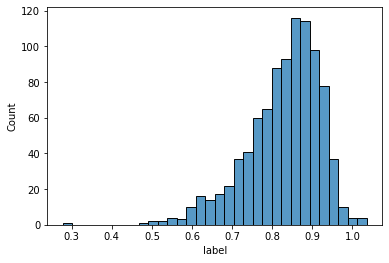

In [89]:
import seaborn as sns
sns.histplot(d['label'])

In [95]:
d.loc[:,'label'].isna().sum()

10

In [101]:
import pandas as pd
from sklearn import preprocessing

x = d['label'].values.reshape(-1, 1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
d['speaks_catalan'] = pd.DataFrame(x_scaled)